In [1]:
import gettext
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import mean_squared_error



In [2]:
# Load the data
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
ID = test['Id']

In [3]:
# View the data as a preview
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
# Viewing information about the data variables
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
#Identify the features in which there are more than 30% of the data nulled out
missing_features = []
for ftr in train.columns.values:
    if train[ftr].isnull().sum() > (len(train) // 3.0):
        missing_features.append(ftr)
        print(ftr)

Alley
FireplaceQu
PoolQC
Fence
MiscFeature


In [6]:
train.drop(missing_features, axis=1, inplace=True)
test.drop(missing_features, axis=1, inplace=True)

In [7]:
train.shape

(1460, 76)

<AxesSubplot:>

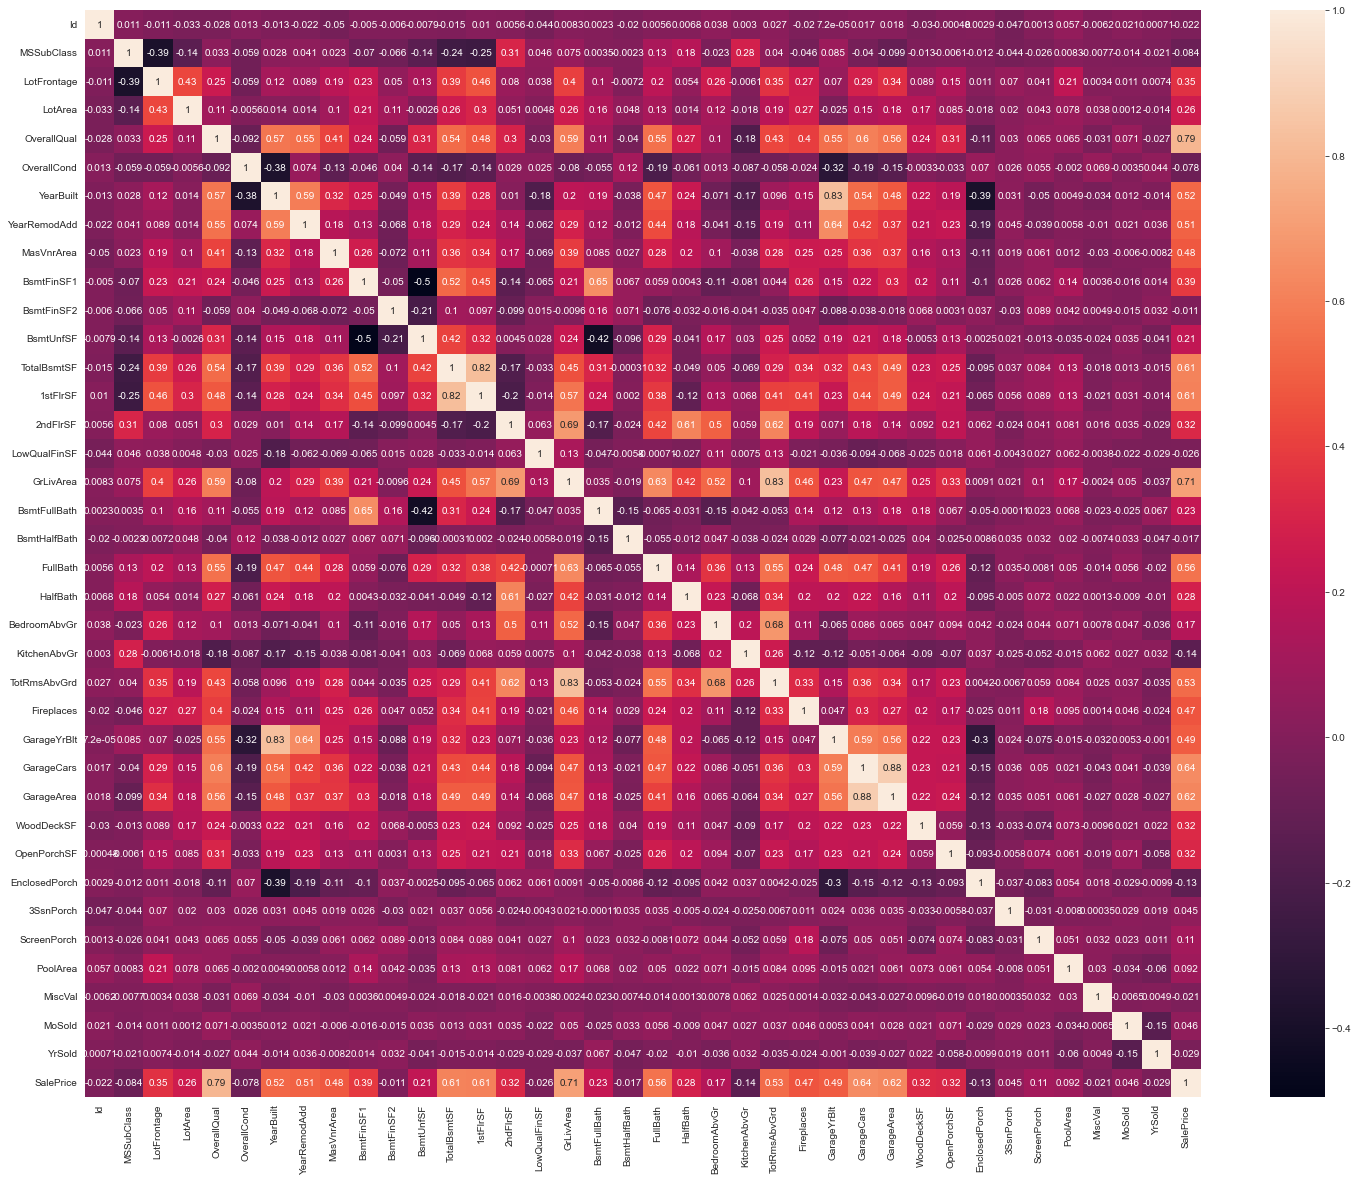

In [8]:
# Look for correlations between the features to prep for removing correlated features
plt.figure(figsize=(25, 20))
sns.heatmap(train.corr(), annot=True)

In [9]:
# Remove features that are highly correlated
cols_to_remove = []
corltn_data = train.corr()
corltn_vals = corltn_data['SalePrice'].sort_values(ascending=False)
corltn_vals = abs(corltn_vals).sort_values(ascending=False)
for col in range(len(corltn_vals)):
    if abs(corltn_vals[col]) < 0.2:
        cols_to_remove.append(corltn_vals.index[col])
        train = train.drop([corltn_vals.index[col]], axis=1)

train.shape

(1460, 61)

In [10]:
cols_to_remove

['BedroomAbvGr',
 'KitchenAbvGr',
 'EnclosedPorch',
 'ScreenPorch',
 'PoolArea',
 'MSSubClass',
 'OverallCond',
 'MoSold',
 '3SsnPorch',
 'YrSold',
 'LowQualFinSF',
 'Id',
 'MiscVal',
 'BsmtHalfBath',
 'BsmtFinSF2']

In [11]:
test.drop(cols_to_remove, inplace=True, axis=1)

In [12]:
# One Hot Encoding of the Variables
onehot_encoded_cols = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
                       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
                       'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType',
                       'SaleCondition']

# Ordinal Encoding of Variables
# Col : Coverage : Mapping
ordinal_encoded_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']

ordinal_encoding_dict = [{'col': 'ExterQual', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}},
                         {'col': 'ExterCond', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}},
                         {'col': 'BsmtQual', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}},
                         {'col': 'BsmtCond', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}},
                         {'col': 'BsmtExposure', 'mapping': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}},
                         {'col': 'BsmtFinType1',
                          'mapping': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}},
                         {'col': 'BsmtFinType2',
                          'mapping': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}},
                         {'col': 'HeatingQC', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}},
                         {'col': 'KitchenQual', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}},
                         {'col': 'GarageQual', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}},
                         {'col': 'GarageCond', 'mapping': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}}]



In [13]:
import category_encoders as ce

ordinal_encoder = ce.OrdinalEncoder(cols=ordinal_encoded_cols, mapping=ordinal_encoding_dict)
onehot_encoder = ce.OneHotEncoder(cols=onehot_encoded_cols)

In [14]:
train.shape

(1460, 61)

In [15]:
test.shape

(1459, 60)

In [16]:
ordinal_encoder.fit(train)

OrdinalEncoder(cols=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond'],
               mapping=[{'col': 'ExterQual',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'ExterCond',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'BsmtQual',
                         'mapping': {'Ex': 5, 'Fa': 2...
                         'mapping': {'ALQ': 5, 'BLQ': 4, 'GLQ': 6, 'LwQ': 2,
                                     'NA': 0, 'Rec': 3, 'Unf': 1}},
                        {'col': 'HeatingQC',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'Kitch

In [17]:
ordinal_encoder.fit(test)

OrdinalEncoder(cols=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond'],
               mapping=[{'col': 'ExterQual',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'ExterCond',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'BsmtQual',
                         'mapping': {'Ex': 5, 'Fa': 2...
                         'mapping': {'ALQ': 5, 'BLQ': 4, 'GLQ': 6, 'LwQ': 2,
                                     'NA': 0, 'Rec': 3, 'Unf': 1}},
                        {'col': 'HeatingQC',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'Kitch

In [18]:
onehot_encoder.fit(train)

OneHotEncoder(cols=['MSZoning', 'Street', 'LotShape', 'LandContour',
                    'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
                    'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                    'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
                    'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
                    'Electrical', 'Functional', 'GarageType', 'GarageFinish',
                    'PavedDrive', 'SaleType', 'SaleCondition'])

In [19]:
ordinal_encoder.fit(test)

OrdinalEncoder(cols=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
                     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                     'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond'],
               mapping=[{'col': 'ExterQual',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'ExterCond',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'BsmtQual',
                         'mapping': {'Ex': 5, 'Fa': 2...
                         'mapping': {'ALQ': 5, 'BLQ': 4, 'GLQ': 6, 'LwQ': 2,
                                     'NA': 0, 'Rec': 3, 'Unf': 1}},
                        {'col': 'HeatingQC',
                         'mapping': {'Ex': 5, 'Fa': 2, 'Gd': 4, 'Po': 1,
                                     'TA': 3}},
                        {'col': 'Kitch

In [20]:
train = ordinal_encoder.fit_transform(train)
test = ordinal_encoder.fit_transform(test)

In [21]:
train.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition,SalePrice
0,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,2,548,3.0,3.0,Y,0,61,WD,Normal,208500
1,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,2,460,3.0,3.0,Y,298,0,WD,Normal,181500
2,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,2,608,3.0,3.0,Y,0,42,WD,Normal,223500
3,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,3,642,3.0,3.0,Y,0,35,WD,Abnorml,140000
4,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,3,836,3.0,3.0,Y,192,84,WD,Normal,250000


In [22]:
test.head()

,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,SaleType,SaleCondition
0,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,Unf,1.0,730.0,3.0,3.0,Y,140,0,WD,Normal
1,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,Unf,1.0,312.0,3.0,3.0,Y,393,36,WD,Normal
2,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,Fin,2.0,482.0,3.0,3.0,Y,212,34,WD,Normal
3,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,Fin,2.0,470.0,3.0,3.0,Y,360,36,WD,Normal
4,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,...,RFn,2.0,506.0,3.0,3.0,Y,0,82,WD,Normal


In [23]:
train = onehot_encoder.fit_transform(train)
test = onehot_encoder.fit_transform(test)

In [24]:
train.head()

,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5,LotFrontage,LotArea,Street_1,Street_2,LotShape_1,...,SaleType_7,SaleType_8,SaleType_9,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_6,SalePrice
0,1,0,0,0,0,65.0,8450,1,0,1,...,0,0,0,1,0,0,0,0,0,208500
1,1,0,0,0,0,80.0,9600,1,0,1,...,0,0,0,1,0,0,0,0,0,181500
2,1,0,0,0,0,68.0,11250,1,0,0,...,0,0,0,1,0,0,0,0,0,223500
3,1,0,0,0,0,60.0,9550,1,0,0,...,0,0,0,0,1,0,0,0,0,140000
4,1,0,0,0,0,84.0,14260,1,0,0,...,0,0,0,1,0,0,0,0,0,250000


In [25]:
test.head()

,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,MSZoning_5,MSZoning_6,LotFrontage,LotArea,Street_1,Street_2,...,SaleType_7,SaleType_8,SaleType_9,SaleType_10,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_6
0,1,0,0,0,0,0,80.0,11622,1,0,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,81.0,14267,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,74.0,13830,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,78.0,9978,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,0,0,0,0,43.0,5005,1,0,...,0,0,0,0,1,0,0,0,0,0


In [26]:
# Replace NaN values with 0
train = train.fillna(0)
test = test.fillna(0)

In [27]:
train_data = train.values
y_train = train_data[:, -1].reshape(train_data.shape[0], 1)
x_train = train_data[:, :-1]

In [28]:
test_data = test.values
y_test = test_data[:, -1].reshape(test_data.shape[0], 1)
x_test = test_data[:, :-1]

In [29]:
print("Shape of X_train :", x_train.shape)
print("Shape of Y_train :", y_train.shape)
print("Shape of X_test :", x_test.shape)
print("Shape of Y_test :", y_test.shape)

Shape of X_train : (1460, 219)
Shape of Y_train : (1460, 1)
Shape of X_test : (1459, 208)
Shape of Y_test : (1459, 1)


In [30]:
x_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [31]:
X = np.vstack((np.ones((x_train.shape[0], )), x_train.T)).T
X_test = np.vstack((np.ones((x_test.shape[0], )), x_test.T)).T

In [32]:
X

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

In [33]:
def model(X, Y, learning_rate, iteration):
    m = Y.size
    theta = np.zeros((X.shape[1], 1))
    cost_list = []
    for i in range(iteration):
        y_pred = np.dot(X, theta)
        cost = (1/(2*m))*np.sum(np.square(y_pred - Y))
        d_theta = (1/m)*np.dot(X.T, y_pred - Y)
        theta = theta - learning_rate*d_theta
        cost_list.append(cost)
        # to print the cost for 10 times
    if(i%(iteration/10) == 0):
        print("Cost is :", cost)
    return theta, cost_list

In [34]:
iteration = 14590
learning_rate = 0.0000000005
theta, cost_list = model(X, y_train, learning_rate = learning_rate, iteration =iteration)

In [35]:
cost_list

[19519633853.882877,
 17124026566.485373,
 15217344089.847757,
 13697977589.12057,
 12485448244.708845,
 11516013070.598461,
 10739184544.046934,
 10114974010.974388,
 9611708351.09339,
 9204300688.02557,
 8872880721.481537,
 8601709894.715097,
 8378322163.078869,
 8192843447.811388,
 8037452615.782066,
 7905954553.5407295,
 7793442024.607374,
 7696027846.692842,
 7610632765.159827,
 7534817440.167607,
 7466649373.645384,
 7404597510.028572,
 7347448755.739044,
 7294241859.200593,
 7244215041.103329,
 7196764515.423576,
 7151411636.364501,
 7107776877.376295,
 7065559221.4609165,
 7024519837.434065,
 6984469150.839449,
 6945256603.565641,
 6906762543.02472,
 6868891798.030479,
 6831568590.611282,
 6794732505.93762,
 6758335300.319574,
 6722338372.989849,
 6686710763.632122,
 6651427566.321083,
 6616468673.27771,
 6581817779.8516655,
 6547461596.406392,
 6513389224.079647,
 6479591660.340222,
 6446061407.348657,
 6412792161.743014,
 6379778568.916785,
 6347016028.377297,
 6314500539.562

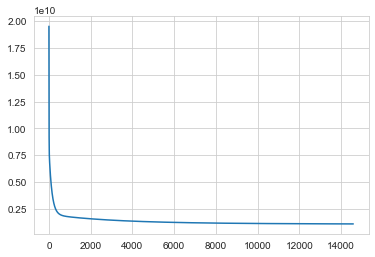

In [36]:
rng = np.arange(0, iteration)
plt.plot(rng, cost_list)
plt.show()

In [37]:
submission = pd.DataFrame({'Id': ID, 'SalePrice': cost_list})
submission.to_csv('submission.csv', index=False)
# Save CSV to disk


ValueError: array length 14590 does not match index length 1459